<a href="https://colab.research.google.com/github/dennistay1981/Resources/blob/main/Code%20and%20data%20in%20publications/Chapter%3A%20Machine%20learning%20and%20healthcare%20discourse%20research%3A%20sample%20applications/Machine_learning_and_healthcare_discourse_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Supervised learning example: survival regression of metaphors

In [ ]:
#Import Python libraries
!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Import data
df = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Machine%20learning%20and%20healthcare%20discourse%20research%3A%20sample%20applications/Survival.csv')


In [ ]:
"""
Figure 1
"""
#Plot survival function with subgroups and median lines (INITIATOR)
ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=df.loc[df.Initiator =='T'].Turns,
               event_observed=df.loc[df.Initiator =='T'].Attrition, label='Therapist').plot_survival_function(ax=ax)
ax.axvline(kmf_A.median_survival_time_, linestyle='--', color='blue', label=f'Median time: {kmf_A.median_survival_time_:.1f}')

kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=df.loc[df.Initiator =='C'].Turns,
               event_observed=df.loc[df.Initiator =='C'].Attrition, label='Client').plot_survival_function(ax=ax)
ax.axvline(kmf_B.median_survival_time_, linestyle='--', color='orange', label=f'Median time: {kmf_B.median_survival_time_:.1f}')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 26))
plt.title('Survival curve by INITIATOR')

#Plot survival function with subgroups and median lines  (APPROACH)
ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=df.loc[df.Approach =='CBT'].Turns,
               event_observed=df.loc[df.Approach =='CBT'].Attrition, label='CBT').plot_survival_function(ax=ax)
ax.axvline(kmf_A.median_survival_time_, linestyle='--', color='blue', label=f'Median time: {kmf_A.median_survival_time_:.1f}')

kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=df.loc[df.Approach =='PA'].Turns,
               event_observed=df.loc[df.Approach =='PA'].Attrition, label='PA').plot_survival_function(ax=ax)

ax.axvline(kmf_B.median_survival_time_, linestyle='--', color='orange', label=f'Median time: {kmf_B.median_survival_time_:.1f}')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 26))
plt.title('Survival curve by APPROACH')

In [ ]:
"""
Fit Cox’s Proportional Hazards regression model
"""
coxph = CoxPHFitter()
coxph.fit(df, duration_col='Turns', event_col='Attrition', formula="Initiator+Approach") #can also add cluster_col='XX' to account for clustered subjects (like 'random effects')
coxph.print_summary()


## Unsupervised learning example: clusters as emergent synchrony measures

In [1]:
#import Python libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans

In [ ]:
#Import Psychoanalysis dataset
df = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Machine%20learning%20and%20healthcare%20discourse%20research%3A%20sample%20applications/Psychoanalysis.csv', index_col='Session')

#scale features for better clustering outcomes
scaler=StandardScaler()
scaler.fit(df)
df=pd.DataFrame(scaler.transform(df),columns=df.columns,index=df.index)


"""
K-means clustering
"""
#determine the optimal number of clusters with silhouette scores
from sklearn.metrics import silhouette_score

num_clusters = np.arange(2, 11)
silhouette_scores = []

for i in num_clusters:
    # Iterate over each k, train model, and calculate silhouette score
    model = KMeans(n_clusters=i)
    labels = model.fit_predict(df)
    silhouette_scores.append(silhouette_score(df, labels))

#generate silhouette plot
plt.plot(num_clusters,  silhouette_scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette scores')
plt.title('Silhouette plot')
plt.xticks(num_clusters)
plt.show()

#generate cluster centroids and labels using the optimal number of clusters (3 for psychoanalysis, 2 for CBT)
model = KMeans(n_clusters=3)
labels = model.fit_predict(df)

#obtain cluster centroid positions for later plotting
cluster_centres = model.cluster_centers_

"""
Generate 2D-scatterplot to visualize clustering solution
"""
from sklearn.decomposition import PCA as sklearnPCA
#specify two principal components
pca = sklearnPCA(n_components=2)
#reduce the cluster centroid locations into two dimensions
cent=pca.fit_transform(cluster_centres).T
#use data.iloc to remove cluster labels in the rightmost column before reducing the data
reduced=pd.DataFrame(pca.fit_transform(df),columns=['Dim_1','Dim_2'],index=df.index)

#generate scatterplot and color according to clusters
sns.scatterplot(x='Dim_1', y='Dim_2', hue=labels, data=reduced, palette='tab10', s=30)
#plot cluster centroids
plt.plot(cent[0],cent[1],'rx',markersize=15)
#annotate each object
for i in range(reduced.shape[0]):
    plt.text(x=reduced.Dim_1[i]+0.05, y=reduced.Dim_2[i]+0.05, s=reduced.index[i],
             fontdict=dict(color='black',size=8))
plt.legend(title='cluster')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Psychoanalysis dyad")
plt.tight_layout()
plt.show()


<Axes: >

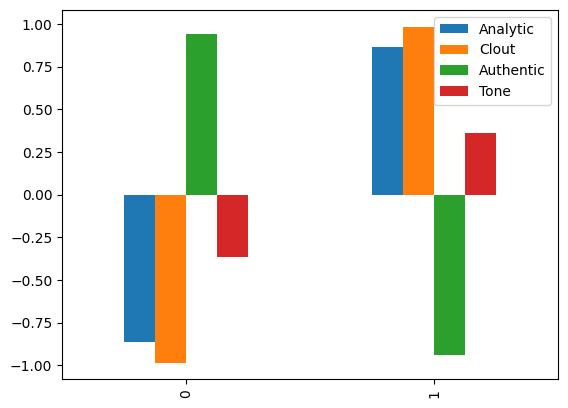

In [35]:
"""
Repeat the above for CBT dataset
"""
#Import CBT dataset
df = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Machine%20learning%20and%20healthcare%20discourse%20research%3A%20sample%20applications/CBT.csv', index_col='Session' )

#scale features for better clustering outcomes
scaler=StandardScaler()
scaler.fit(df)
df=pd.DataFrame(scaler.transform(df),columns=df.columns,index=df.index)


"""
K-means clustering
"""
#determine the optimal number of clusters with silhouette scores
from sklearn.metrics import silhouette_score

num_clusters = np.arange(2, 11)
silhouette_scores = []

for i in num_clusters:
    # Iterate over each k, train model, and calculate silhouette score
    model = KMeans(n_clusters=i)
    labels = model.fit_predict(df)
    silhouette_scores.append(silhouette_score(df, labels))

#generate silhouette plot
plt.plot(num_clusters,  silhouette_scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette scores')
plt.title('Silhouette plot')
plt.xticks(num_clusters)
plt.show()

#generate cluster centroids and labels using the optimal number of clusters (3 for psychoanalysis, 2 for CBT)
model = KMeans(n_clusters=2)
labels = model.fit_predict(df)

#obtain cluster centroid positions for later plotting
cluster_centres = model.cluster_centers_


"""
Generate 2D-scatterplot to visualize clustering solution
"""
from sklearn.decomposition import PCA as sklearnPCA
#specify two principal components
pca = sklearnPCA(n_components=2)
#reduce the cluster centroid locations into two dimensions
cent=pca.fit_transform(cluster_centres).T
#use data.iloc to remove cluster labels in the rightmost column before reducing the data
reduced=pd.DataFrame(pca.fit_transform(df),columns=['Dim_1','Dim_2'],index=df.index)

#generate scatterplot and color according to clusters
sns.scatterplot(x='Dim_1', y='Dim_2', hue=labels, data=reduced, palette='tab10', s=30)
#plot cluster centroids
plt.plot(cent[0],cent[1],'rx',markersize=15)
#annotate each object
for i in range(reduced.shape[0]):
    plt.text(x=reduced.Dim_1[i]+0.05, y=reduced.Dim_2[i]+0.05, s=reduced.index[i],
             fontdict=dict(color='black',size=8))
plt.legend(title='cluster')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("CBT dyad")
plt.tight_layout()
plt.show()


"""
Plot cluster centroids in terms of LIWC scores
"""
pd.DataFrame(cluster_centres, columns=df.columns).plot(kind='bar')
